In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


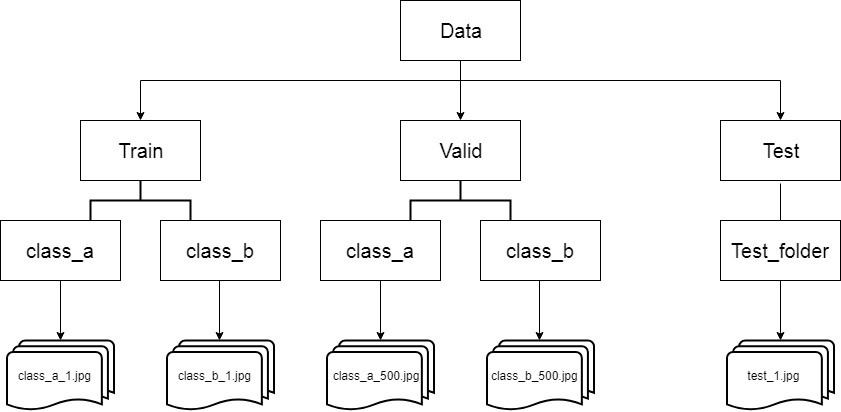

*Great notebook and resource on how to set up the directory for using Tensorflow's ImageDataGenerator object:*

https://www.kaggle.com/code/ggsri123/p1-dogsvscats-using-tensorflow  
https://vijayabhaskar96.medium.com/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720

In [2]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import tqdm
import shutil

In [3]:
# extract test file into tmp folder

zip_ref = zipfile.ZipFile('../input/dogs-vs-cats/test1.zip', 'r')
zip_ref.extractall("../tmp")
zip_ref.close()

In [4]:
# extract train file into tmp folder

zip_ref = zipfile.ZipFile('../input/dogs-vs-cats/train.zip', 'r')
zip_ref.extractall("../tmp")
zip_ref.close()

In [5]:
# set up training and testing directories 

base_dir = '../tmp'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test1')

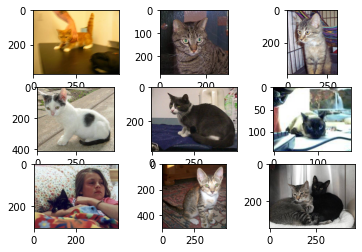

In [6]:
# visualize the cat images

import matplotlib.pyplot as plt
from matplotlib.image import imread

folder  = train_dir + '/'
for i in range(9):
    
    # 3x3 subplot
    plt.subplot(330 + 1 + i)
    
    # get files labeld as cat
    filename = folder + 'cat.' + str(i) +  '.jpg'
    
    image = imread(filename)
    plt.imshow(image)
plt.show()

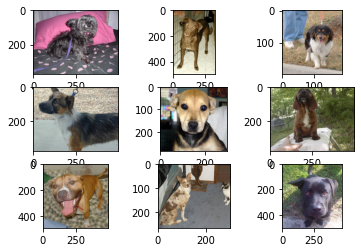

In [7]:
# visualize the dog images

folder  = train_dir + '/'
for i in range(9):
    
    # 3x3 subplot
    plt.subplot(330 + 1 + i)
    
    # get files labeld as dog
    filename = folder + 'dog.' + str(i) +  '.jpg'
    
    image = imread(filename)
    plt.imshow(image)
plt.show()

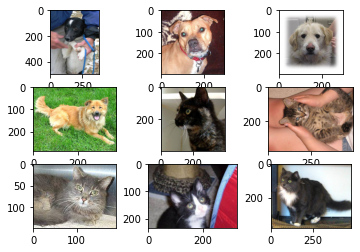

In [8]:
# visualize the test images

folder  = test_dir + '/'
for i in range(1,10):
    
    # 3x3 subplot
    plt.subplot(330 + 1 + i-1)
    
    # get files labeld as dog
    filename = folder + str(i) +  '.jpg'
    
    image = imread(filename)
    plt.imshow(image)
plt.show()

In [9]:
# number of images in the training file
train_file_list = os.listdir('../tmp/train')
test_file_list = os.listdir('../tmp/test1')
print('Number of train images:', len(train_file_list))

# get lists of dog and cat file names to move them later
dog_filenames = [fn for fn in train_file_list if fn.startswith('dog')]
cat_filenames = [fn for fn in train_file_list if fn.startswith('cat')]

# shuffle into train and validation sets (90/10 split); dataset_filenames is a tuple of (dog train, dog val, cat train, cat val)
dataset_filenames = train_test_split(dog_filenames, cat_filenames, test_size=0.1, shuffle=True, random_state=42)

train_dog, valid_dog, train_cat, valid_cat = [fns for fns in dataset_filenames]

# check totals
train_dog_total, valid_dog_total, train_cat_total, valid_cat_total = [len(fns) for fns in dataset_filenames]
train_total = train_dog_total + train_cat_total
valid_total = valid_dog_total + valid_cat_total

print('Train: {}, val: {}, test: {}'.format(train_total, valid_total, len(test_file_list)))

Number of train images: 25000
Train: 22500, val: 2500, test: 12500


In [10]:
# create the directories for data preprocessing

TRAIN_DIR_DOG = train_dir + '/dog'
TRAIN_DIR_CAT = train_dir + '/cat'

valid_dir = base_dir + '/valid'
VALID_DIR_DOG = valid_dir + '/dog'
VALID_DIR_CAT = valid_dir + '/cat'

TEST_DIR = test_dir + '/test'

In [11]:
# make training and validation directories, move files to appropriate directories

make_dirs = [TRAIN_DIR_DOG, VALID_DIR_DOG, TRAIN_DIR_CAT, VALID_DIR_CAT]

for dir, fns in zip(make_dirs, dataset_filenames):
    os.makedirs(dir, exist_ok=True)
    for fn in tqdm.tqdm(fns):
        shutil.move(os.path.join(train_dir, fn), dir)
    print('elements in {}: {}'.format(dir, len(os.listdir(dir))))
    
os.makedirs(TEST_DIR, exist_ok=True)
for fn in tqdm.tqdm(os.listdir(test_dir)):
    shutil.move(os.path.join(test_dir, fn), TEST_DIR)
print('elements in {}: {}'.format(TEST_DIR, len(os.listdir(TEST_DIR))))    

100%|██████████| 11250/11250 [00:00<00:00, 19801.81it/s]


elements in ../tmp/train/dog: 11250


100%|██████████| 1250/1250 [00:00<00:00, 17752.26it/s]


elements in ../tmp/valid/dog: 1250


100%|██████████| 11250/11250 [00:00<00:00, 20001.88it/s]


elements in ../tmp/train/cat: 11250


100%|██████████| 1250/1250 [00:00<00:00, 20615.94it/s]


elements in ../tmp/valid/cat: 1250


100%|██████████| 12501/12501 [00:00<00:00, 20192.58it/s]

elements in ../tmp/test1/test: 12500


In [12]:
from tensorflow.keras.applications.inception_v3 import InceptionV3


# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = 'imagenet')


# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False

2022-08-02 17:28:59.405297: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-02 17:28:59.491141: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-02 17:28:59.492007: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-02 17:28:59.493843: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

87924736/87910968 [==============================] - 1s 0us/step


In [13]:
last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(pre_trained_model.input, x)

In [14]:
# lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(0.001, decay_steps = 100 * 1000, # steps_per_epoch * 1000
#                                                             decay_rate=1,
#                                                             staircase=False)

# model.compile(optimizer=tf.keras.optimizers.Adam(lr_schedule),
#              loss='binary_crossentropy',
#              metrics=['accuracy'])

callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=200,
                                            verbose=1,
                                            mode='auto',
                                            restore_best_weights=False)

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Data Preprocessing

In [15]:
train_datagen = ImageDataGenerator(rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   rescale = 1.0/255.,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale = 1.0/255.)


train_generator = train_datagen.flow_from_directory(train_dir,
                                                   batch_size=32,
                                                   class_mode='binary',
                                                    shuffle=True,
                                                   target_size=(150, 150))

validation_generator = test_datagen.flow_from_directory(valid_dir,
                                                       batch_size=32,
                                                       class_mode='binary',
                                                        shuffle=True,
                                                       target_size=(150, 150))

test_generator = test_datagen.flow_from_directory(test_dir,
                                                 batch_size=1,
                                                 class_mode=None,
                                                  shuffle=False,
                                                  target_size=(150, 150))

STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n // validation_generator.batch_size

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [16]:
history = model.fit(train_generator,
                    steps_per_epoch = 100,
                   epochs=20,
                   validation_data = validation_generator,
                    validation_steps = 50,
                   verbose=2,
                    callbacks=[callbacks]
                   ) 

2022-08-02 17:29:10.607655: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-08-02 17:29:17.755566: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


100/100 - 43s - loss: 1.4271 - accuracy: 0.8391 - val_loss: 0.2111 - val_accuracy: 0.9312
Epoch 2/20
100/100 - 29s - loss: 0.2663 - accuracy: 0.8966 - val_loss: 0.2435 - val_accuracy: 0.9225
Epoch 3/20
100/100 - 28s - loss: 0.2576 - accuracy: 0.9103 - val_loss: 0.1436 - val_accuracy: 0.9544
Epoch 4/20
100/100 - 28s - loss: 0.2255 - accuracy: 0.9084 - val_loss: 0.2201 - val_accuracy: 0.9287
Epoch 5/20
100/100 - 28s - loss: 0.2122 - accuracy: 0.9172 - val_loss: 0.2307 - val_accuracy: 0.9431
Epoch 6/20
100/100 - 28s - loss: 0.1918 - accuracy: 0.9269 - val_loss: 0.1424 - val_accuracy: 0.9600
Epoch 7/20
100/100 - 28s - loss: 0.2177 - accuracy: 0.9228 - val_loss: 0.1037 - val_accuracy: 0.9669
Epoch 8/20
100/100 - 28s - loss: 0.2117 - accuracy: 0.9184 - val_loss: 0.1325 - val_accuracy: 0.9563
Epoch 9/20
100/100 - 28s - loss: 0.1728 - accuracy: 0.9406 - val_loss: 0.1463 - val_accuracy: 0.9556
Epoch 10/20
100/100 - 29s - loss: 0.2021 - accuracy: 0.9253 - val_loss: 0.1435 - val_accuracy: 0.9556


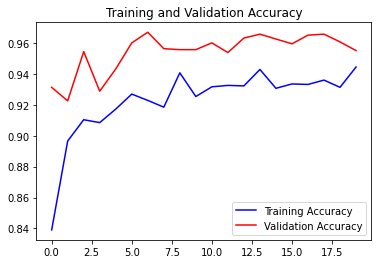

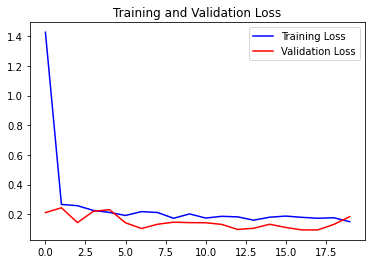

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [18]:
predictions = model.predict(test_generator,
                           verbose=1)

12500/12500 [==============================] - 144s 11ms/step
